## Imports and Set seed

In [33]:
import re
import math
import ast
import random
import builtins
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,f1_score
from functools import partial
import matplotlib.pyplot as plt

In [34]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

## Experiment -1: LSTM and GRU with Word2Vec and FastText

In [ ]:
# import torch
# from torch import nn

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hyperparameters
# HIDDEN_DIM = 256

# class LSTMClassifier(nn.Module):
#     def __init__(self, embedding_matrix, hidden_dim, num_labels):
#         super(LSTMClassifier, self).__init__()
#         vocab_size, embedding_dim = embedding_matrix.shape
#         self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, num_labels)

#     def forward(self, x):
#         x = self.embedding(x)
#         output, _ = self.lstm(x)
#         logits = self.fc(output)
#         return logits

# class GRUClassifier(nn.Module):
#     def __init__(self, embedding_matrix, hidden_dim, num_labels):
#         super(GRUClassifier, self).__init__()
#         vocab_size, embedding_dim = embedding_matrix.shape
#         self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, num_labels)

#     def forward(self, x):
#         x = self.embedding(x)
#         output, _ = self.gru(x)
#         logits = self.fc(output)
#         return logits

# # Example loading pretrained embeddings
# # Assume word2vec_tensor and fasttext_tensor are torch.FloatTensors of shape [vocab_size, embedding_dim]

# # LSTM with Word2Vec
# lstm_word2vec_model = LSTMClassifier(word2vec_tensor, HIDDEN_DIM, NUM_LABELS).to(device)

# # GRU with Word2Vec
# gru_word2vec_model = GRUClassifier(word2vec_tensor, HIDDEN_DIM, NUM_LABELS).to(device)

# # LSTM with FastText
# lstm_fasttext_model = LSTMClassifier(fasttext_tensor, HIDDEN_DIM, NUM_LABELS).to(device)

# # GRU with FastText
# gru_fasttext_model = GRUClassifier(fasttext_tensor, HIDDEN_DIM, NUM_LABELS).to(device)

## Part 1 : Classification Model (Transformer - Token wise classification)

In [35]:
# basic model + training config
VOCAB_SIZE = 10000
MAX_LEN = 641
EMBEDDING_DIM = 256
NUM_HEADS = 8
FF_DIM = 256
NUM_TRANSFORMER_BLOCKS = 10
DROPOUT_RATE = 0.1
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 3e-5
ADAM_EPSILON = 1e-7
WEIGHT_DECAY = 0.01
GRADIENT_CLIP_NORM = 1.0


## 1.1 Read and preprocess Dataset

In [36]:
# load and process data
df = pd.read_csv("1k.csv")
essay = {'tokens': [], 'labels': []}

# training steps
NUM_TRAINING_STEPS = (len(df) * 0.8 / BATCH_SIZE) * EPOCHS
NUM_WARMUP_STEPS = int(NUM_TRAINING_STEPS * 0.1)

for i, row in df.iterrows():
    ess = ast.literal_eval(row['tokens'])
    lab = ast.literal_eval(row['labels'])
    essay['tokens'].append(ess)
    essay['labels'].append(lab)

df = pd.DataFrame(essay)
print(f"{len(df)}")  # total samples


1000


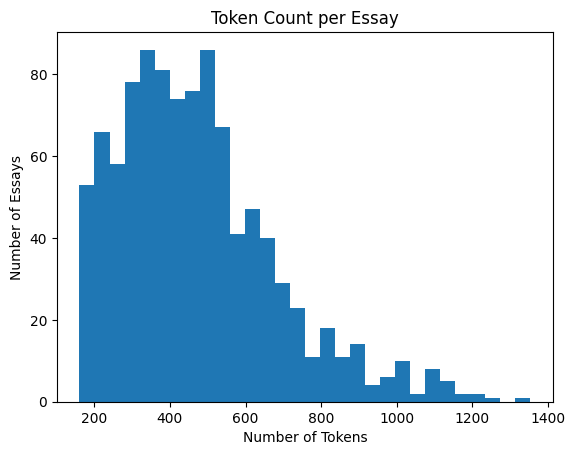

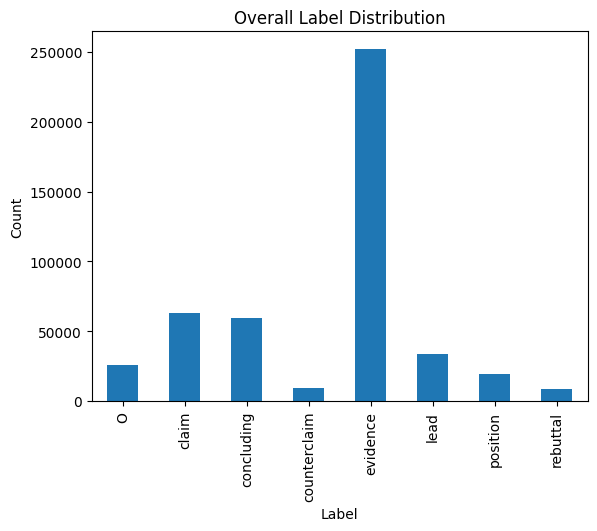

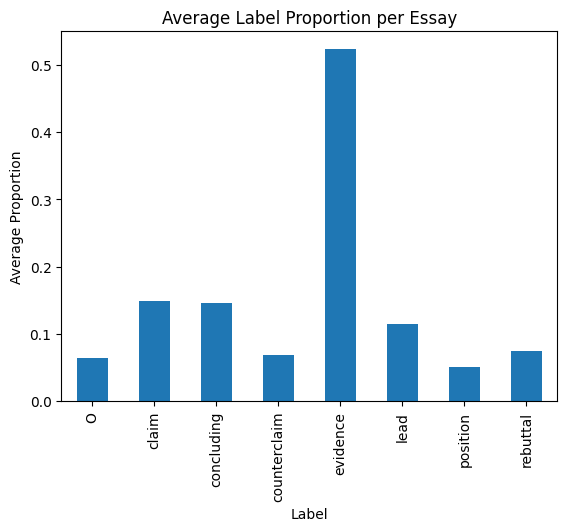

→ Essays: 1000
→ Token‐Count Stats:
 count    1000.000000
mean      472.095000
std       211.329956
min       161.000000
25%       317.500000
50%       441.000000
75%       582.250000
max      1353.000000
Name: token_count, dtype: float64

→ Label Counts:
 O                25811
claim            62905
concluding       59540
counterclaim      9550
evidence        252033
lead             33761
position         19714
rebuttal          8781
Name: count, dtype: int64


In [37]:
df_essay = pd.DataFrame({'tokens': essay['tokens'],'labels': essay['labels']})
df_essay['token_count'] = df_essay['tokens'].apply(len)
plt.figure()
plt.hist(df_essay['token_count'], bins=30)
plt.title("Token Count per Essay")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Essays")
plt.show()


all_labels = pd.Series([lbl for labels in df_essay['labels'] for lbl in labels])
label_counts = all_labels.value_counts().sort_index()
plt.figure()
label_counts.plot(kind='bar')
plt.title("Overall Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()



label_props = df_essay['labels'].apply(lambda lbls: pd.Series(lbls).value_counts(normalize=True))
avg_props = label_props.mean().sort_index()
plt.figure()
avg_props.plot(kind='bar')
plt.title("Average Label Proportion per Essay")
plt.xlabel("Label")
plt.ylabel("Average Proportion")
plt.show()


print("→ Essays:", len(df_essay))
print("→ Token‐Count Stats:\n", df_essay['token_count'].describe())
print("\n→ Label Counts:\n", label_counts)


In [38]:
# label setup
all_labels_list = [label for sublist in df['labels'] for label in sublist]
label_list = sorted(list(set(all_labels_list)))
NUM_LABELS = len(label_list)
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
PAD_LABEL_ID = label2id.get('O', 0)

# vocab setup
all_tokens = [token.lower() for sublist in df['tokens'] for token in sublist]
word_counts = pd.Series(all_tokens).value_counts()
vocab = word_counts.head(VOCAB_SIZE - 2).index.tolist()
word2id = {word: i + 2 for i, word in enumerate(vocab)}
word2id['<PAD>'] = 0
word2id['<UNK>'] = 1
id2word = {i: word for word, i in word2id.items()}
ACTUAL_VOCAB_SIZE = len(word2id)
PAD_TOKEN_ID = word2id['<PAD>']

print(f"\nUnique Labels:{label_list}")
print(f"Number of Labels:{NUM_LABELS}")
print(f"Label to ID mapping:{label2id}")
print(f"Padding Label ID:{PAD_LABEL_ID}")
print(f"Actual  Vocabulary Size:{ACTUAL_VOCAB_SIZE}")


Unique Labels:['O', 'claim', 'concluding', 'counterclaim', 'evidence', 'lead', 'position', 'rebuttal']
Number of Labels:8
Label to ID mapping:{'O': 0, 'claim': 1, 'concluding': 2, 'counterclaim': 3, 'evidence': 4, 'lead': 5, 'position': 6, 'rebuttal': 7}
Padding Label ID:0
Actual  Vocabulary Size:10000


In [39]:
# encode tokens + labels
X = [[word2id.get(token.lower(), word2id['<UNK>']) for token in seq] for seq in df['tokens']]
y = [[label2id[label] for label in seq] for seq in df['labels']]

# pad sequences
X_padded = np.array([seq[:MAX_LEN] + [PAD_TOKEN_ID] * (MAX_LEN - len(seq)) if len(seq) < MAX_LEN else seq[:MAX_LEN] for seq in X])
y_padded = np.array([seq[:MAX_LEN] + [PAD_LABEL_ID] * (MAX_LEN - len(seq)) if len(seq) < MAX_LEN else seq[:MAX_LEN] for seq in y])

# split data
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# recalc steps
NUM_TRAINING_STEPS = (len(X_train_np) // BATCH_SIZE) * EPOCHS
NUM_WARMUP_STEPS = int(NUM_TRAINING_STEPS * 0.1)

# device info
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Train samples: {len(X_train_np)}, Validation samples: {len(X_val_np)}")
print(f"Total training steps: {NUM_TRAINING_STEPS}, Warmup steps: {NUM_WARMUP_STEPS}")
print(f"Using device: {device}")


Train samples: 800, Validation samples: 200
Total training steps: 500, Warmup steps: 50
Using device: cuda


In [40]:
# convert to tensors
X_train = torch.LongTensor(X_train_np)
y_train = torch.LongTensor(y_train_np)
X_val = torch.LongTensor(X_val_np)
y_val = torch.LongTensor(y_val_np)

# create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## 1.2 Define Layers and combine the layers for Transformer

In [41]:
# adds positional info to embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


In [42]:
# one transformer block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate):
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, padding_mask=None):
        x_norm1 = self.layernorm1(x)
        attn_output, _ = self.att(x_norm1, x_norm1, x_norm1, key_padding_mask=padding_mask, need_weights=False)
        attn_output = self.dropout1(attn_output)
        x = x + attn_output

        x_norm2 = self.layernorm2(x)
        ffn_output = self.ffn(x_norm2)
        ffn_output = self.dropout2(ffn_output)
        x = x + ffn_output

        return x


In [43]:
# full transformer model for token classification
class TokenClassifierTransformer(nn.Module):
    def __init__(self, num_transformer_blocks, embed_dim, num_heads, ff_dim,
                 vocab_size, num_labels, max_len, dropout_rate, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len)
        self.dropout = nn.Dropout(dropout_rate)
        self.embed_dim = embed_dim

        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_transformer_blocks)
        ])

        self.classifier = nn.Linear(embed_dim, num_labels)
        self.padding_idx = padding_idx

        self.apply(self._init_weights)  # init all weights

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)
            if module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.weight, 1.0)
            nn.init.constant_(module.bias, 0)

    def forward(self, input_ids):
        padding_mask = (input_ids == self.padding_idx)
        x = self.embedding(input_ids)
        x *= math.sqrt(self.embed_dim)  # scale
        x = self.pos_encoder(x)
        x = self.dropout(x)

        for block in self.encoder_blocks:
            x = block(x, padding_mask=padding_mask)

        logits = self.classifier(x)
        return logits


In [49]:
# init model
model = TokenClassifierTransformer(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    embed_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    vocab_size=ACTUAL_VOCAB_SIZE,
    num_labels=NUM_LABELS,
    max_len=MAX_LEN,
    dropout_rate=DROPOUT_RATE,
    padding_idx=PAD_TOKEN_ID
).to(device)

# optimizer, loss, scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_LABEL_ID)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=NUM_WARMUP_STEPS, num_training_steps=NUM_TRAINING_STEPS)

# param count
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters - {total_params}")


Total Trainable Parameters - 6519816


## 1.3 Train the model

In [50]:
def calculate_accuracy(preds,labels,ignore_index):
    pred_flat=preds.argmax(dim=-1).view(-1)
    labels_flat=labels.view(-1)
    mask=(labels_flat!=ignore_index)
    pred_flat_masked=pred_flat[mask]
    labels_flat_masked=labels_flat[mask]
    correct=(pred_flat_masked==labels_flat_masked).sum().item()
    total=mask.sum().item()
    return correct,total

In [51]:
import matplotlib.pyplot as plt

# 1. Prepare metric containers
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

overall_best_val_acc = 0.0
EPOCHS = 20
for epoch in range(EPOCHS):
    # training
    model.train()
    total_train_loss = total_train_correct = total_train_tokens = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for input_ids, labels in train_pbar:
        input_ids, labels = input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits.view(-1, NUM_LABELS), labels.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_NORM)
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        correct, total = calculate_accuracy(logits.detach(), labels, PAD_LABEL_ID)
        total_train_correct += correct
        total_train_tokens += total
        train_pbar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = (total_train_correct / total_train_tokens) * 100 if total_train_tokens else 0

    # validation
    model.eval()
    total_val_loss = total_val_correct = total_val_tokens = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for input_ids, labels in val_pbar:
            input_ids, labels = input_ids.to(device), labels.to(device)
            logits = model(input_ids)
            loss = criterion(logits.view(-1, NUM_LABELS), labels.view(-1))

            total_val_loss += loss.item()
            correct, total = calculate_accuracy(logits, labels, PAD_LABEL_ID)
            total_val_correct += correct
            total_val_tokens += total
            val_pbar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = (total_val_correct / total_val_tokens) * 100 if total_val_tokens else 0

    # 2. Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

    # log epoch results
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"\tTrain Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"\tVal   Loss: {avg_val_loss:.4f} | Val   Acc: {val_accuracy:.2f}%")

    # save best
    if val_accuracy > overall_best_val_acc:
        print(f"\tNew best validation accuracy: {val_accuracy:.2f}%")
        overall_best_val_acc = val_accuracy

Epoch 1/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/20
	Train Loss: 2.5812 | Train Acc: 41.05%
	Val   Loss: 1.4064 | Val   Acc: 56.58%
	New best validation accuracy: 56.58%


Epoch 2/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/20
	Train Loss: 1.6481 | Train Acc: 52.97%
	Val   Loss: 1.1106 | Val   Acc: 62.70%
	New best validation accuracy: 62.70%


Epoch 3/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/20
	Train Loss: 1.4513 | Train Acc: 56.01%
	Val   Loss: 1.0289 | Val   Acc: 65.27%
	New best validation accuracy: 65.27%


Epoch 4/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/20
	Train Loss: 1.3319 | Train Acc: 58.18%
	Val   Loss: 1.0030 | Val   Acc: 66.69%
	New best validation accuracy: 66.69%


Epoch 5/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/20
	Train Loss: 1.2558 | Train Acc: 59.85%
	Val   Loss: 1.0119 | Val   Acc: 64.80%


Epoch 6/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/20
	Train Loss: 1.2213 | Train Acc: 60.57%
	Val   Loss: 0.9639 | Val   Acc: 67.30%
	New best validation accuracy: 67.30%


Epoch 7/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/20
	Train Loss: 1.1923 | Train Acc: 61.25%
	Val   Loss: 0.9606 | Val   Acc: 66.85%


Epoch 8/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/20
	Train Loss: 1.1672 | Train Acc: 61.56%
	Val   Loss: 0.9425 | Val   Acc: 67.59%
	New best validation accuracy: 67.59%


Epoch 9/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/20
	Train Loss: 1.1501 | Train Acc: 62.02%
	Val   Loss: 0.9409 | Val   Acc: 68.03%
	New best validation accuracy: 68.03%


Epoch 10/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/20
	Train Loss: 1.1409 | Train Acc: 62.22%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 11/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/20
	Train Loss: 1.1340 | Train Acc: 62.29%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 12/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/20
	Train Loss: 1.1380 | Train Acc: 62.12%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 13/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/20
	Train Loss: 1.1371 | Train Acc: 62.21%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 14/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/20
	Train Loss: 1.1374 | Train Acc: 62.27%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 15/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/20
	Train Loss: 1.1356 | Train Acc: 62.30%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 16/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/20
	Train Loss: 1.1353 | Train Acc: 62.27%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 17/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/20
	Train Loss: 1.1374 | Train Acc: 62.19%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 18/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/20
	Train Loss: 1.1393 | Train Acc: 62.13%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 19/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/20
	Train Loss: 1.1387 | Train Acc: 62.17%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


Epoch 20/20 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/20
	Train Loss: 1.1380 | Train Acc: 62.20%
	Val   Loss: 0.9451 | Val   Acc: 67.43%


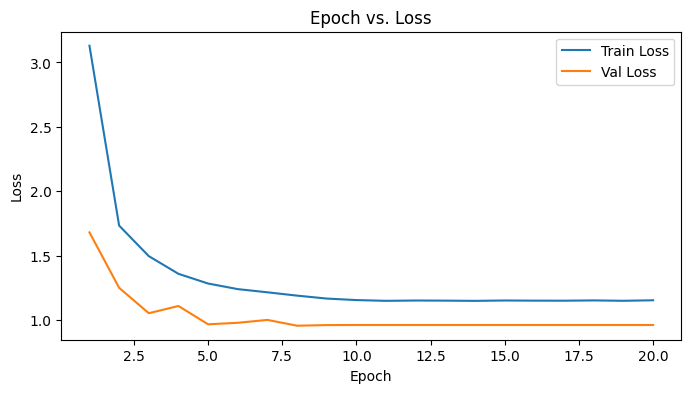

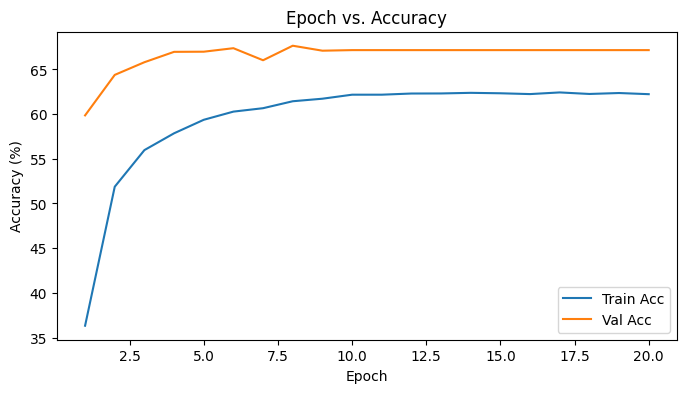

In [47]:
# Loss plot
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()

# Accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs,   label='Val Acc')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
# plt.grid(True)
plt.show()


## 1.4 Test the model

In [ ]:
# eval on one sample
model.eval()
# grab val sample
input_ids_single_np_orig = X_val_np[4:5]
gt_label_ids_single_np_orig = y_val_np[4]
input_ids_single = torch.LongTensor(input_ids_single_np_orig).to(device)

# predict
with torch.no_grad():
    pred_logits_single = model(input_ids_single)
pred_indices_single = torch.argmax(pred_logits_single[0], dim=-1).cpu().numpy()

# convert ids back to tokens/labels
input_ids_single_np = input_ids_single[0].cpu().numpy()
original_tokens, predicted_labels, ground_truth_labels = [], [], []

for token_id, pred_label_id, gt_label_id in zip(
        input_ids_single_np, pred_indices_single, gt_label_ids_single_np_orig):
    if token_id == PAD_TOKEN_ID:
        break  # stop at padding
    original_tokens.append(id2word.get(token_id, '<UNK>'))
    predicted_labels.append(id2label.get(pred_label_id, 'UNK_LABEL'))
    ground_truth_labels.append(id2label.get(gt_label_id, 'UNK_LABEL'))

# show results
print(f"Original Tokens:  {original_tokens}")
print(f"\nPredicted Labels:  {predicted_labels}")
print(f"\nGround Truth Labels:  {ground_truth_labels}")


Original Tokens:  ['attention', 'my', 'fellow', 'citizens', ',', 'we', 'should', 'limit', 'car', 'usage', '\xa0 ', 'because', 'limiting', 'car', 'usage', 'will', 'release', 'stress', ',', 'reduce', 'greenhouse', 'gas', 'emissions', 'from', 'tailpipes', ',', 'and', 'stop', 'smog', '.', '\n\n', 'first', ',', 'we', 'should', 'limit', 'car', 'usage', 'because', 'driving', 'a', 'car', 'can', 'be', 'stressful', '.', 'for', 'example', 'say', 'you', 'just', 'got', 'finished', 'with', 'a', 'hard', 'day', 'of', 'work', 'and', 'it', 'was', 'not', 'the', 'best', 'day', ',', 'you', 'hop', 'in', 'your', 'car', 'and', 'when', 'you', 'start', 'to', 'drive', 'you', 'look', 'ahead', 'and', 'see', 'a', 'trafic', 'jam', '.', 'after', 'working', 'all', 'day', ',', 'getting', 'in', 'a', 'car', 'to', 'wait', 'hours', 'and', 'hours', 'to', 'get', 'home', 'is', 'not', 'peaceful', 'or', 'fun', '.', 'another', 'example', 'would', 'be', 'when', 'you', "'re", 'on', 'the', 'road', 'and', 'the', 'people', 'around', 

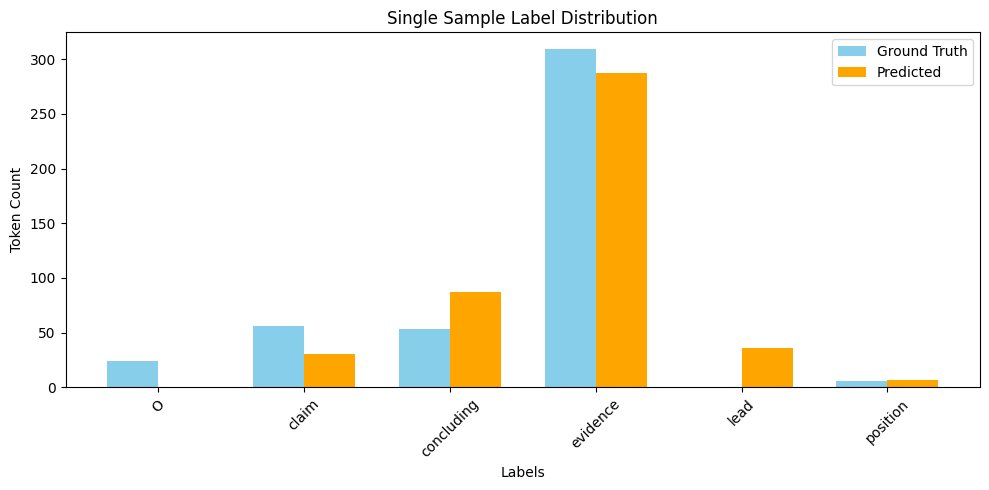

In [ ]:
from collections import Counter

pred_counter = Counter(predicted_labels)
true_counter = Counter(ground_truth_labels)

labels = sorted(set(predicted_labels + ground_truth_labels))
x = np.arange(len(labels))
true_counts = [true_counter.get(label, 0) for label in labels]
pred_counts = [pred_counter.get(label, 0) for label in labels]

plt.figure(figsize=(10, 5))
bar_width = 0.35
plt.bar(x - bar_width/2, true_counts, bar_width, label='Ground Truth', color='skyblue')
plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='orange')

plt.xlabel('Labels')
plt.ylabel('Token Count')
plt.title('Single Sample Label Distribution')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Part 2 : Score Prediction for each of the classes (BERT)

In [53]:
# BERT hyperparams holder
class BertConfig:
    def __init__(self,
                 vocab_size=30522,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 layer_norm_eps=1e-12,
                 pad_token_id=0):
        # basic settings
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_act = hidden_act
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.layer_norm_eps = layer_norm_eps
        self.pad_token_id = pad_token_id

        # head size calc
        if num_attention_heads > 0 and hidden_size % num_attention_heads == 0:
            self.attention_head_size = hidden_size // num_attention_heads
        else:
            self.attention_head_size = hidden_size


## 2.1 Read and Preprocess dataset

In [54]:
class SimpleTokenizer:
    def __init__(self,vocab_limit=5000):
        self.word_to_id={}
        self.id_to_word={}
        self.vocab_limit=vocab_limit
        self.pad_token="[PAD]"
        self.unk_token="[UNK]"
        self.cls_token="[CLS]"
        self.sep_token="[SEP]"
        self.special_tokens=[self.pad_token,self.unk_token,self.cls_token,self.sep_token]
        for i,token in enumerate(self.special_tokens):
            self.word_to_id[token]=i
            self.id_to_word[i]=token
        self.vocab_built=False

    def _basic_tokenize(self,text):
        text=text.lower()
        tokens=re.findall(r"[\w']+|[.,!?;]",text)
        return tokens

    def build_vocab(self,corpus_records):
        if self.vocab_built: return
        print(f"Building vocabulary from {len(corpus_records)} records...")
        word_counts=Counter()
        for record in tqdm(corpus_records,desc="Processing Corpus"):
            segments=record.get("segments",{})
            for dt in segments:
                for text_segment in segments[dt]:
                    tokens=self._basic_tokenize(text_segment)
                    word_counts.update(tokens)
        current_id=len(self.special_tokens)
        sorted_words=sorted(word_counts.items(),key=lambda item: item[1],reverse=True)
        for word,count in tqdm(sorted_words,desc="Adding words to vocab"):
            if word not in self.word_to_id:
                if current_id >= self.vocab_limit: break
                self.word_to_id[word]=current_id
                self.id_to_word[current_id]=word
                current_id += 1
        self.vocab_size=len(self.word_to_id)
        self.pad_token_id=self.word_to_id[self.pad_token]
        self.unk_token_id=self.word_to_id[self.unk_token]
        self.cls_token_id=self.word_to_id[self.cls_token]
        self.sep_token_id=self.word_to_id[self.sep_token]
        self.vocab_built=True
        print(f"Vocabulary building complete. Size: {self.vocab_size}")

    def tokenize(self,text):
        return self._basic_tokenize(text)

    def convert_tokens_to_ids(self,tokens):
        return [self.word_to_id.get(token,self.unk_token_id) for token in tokens]

    def convert_ids_to_tokens(self,ids):
        return [self.id_to_word.get(id,self.unk_token) for id in ids]

    def _pad(self,ids,max_length):
        padding_len=max_length-len(ids)
        return ids+[self.pad_token_id]*padding_len if padding_len>0 else ids

    def _truncate(self,ids,max_length):
        effective_max_len=max_length-2
        return ids[:effective_max_len] if len(ids)>effective_max_len else ids

    def encode_plus(self,text,add_special_tokens=True,max_length=None,padding='max_length',truncation=True,return_tensors=None,return_attention_mask=True):
        tokens=self.tokenize(text)
        if truncation and max_length is not None:
          tokens=self._truncate(tokens,max_length)
        ids=self.convert_tokens_to_ids(tokens)
        if add_special_tokens:
          ids=[self.cls_token_id]+ids+[self.sep_token_id]
        attention_mask=[1]*len(ids)
        if padding=='max_length' and max_length is not None:
            pad_len=max_length-len(ids)
            if pad_len>0:
              ids=ids+[self.pad_token_id]*pad_len; attention_mask=attention_mask+[0]*pad_len
            elif pad_len < 0:
              ids=ids[:max_length]; attention_mask=attention_mask[:max_length]
        output={"input_ids":ids}
        if return_attention_mask:
          output["attention_mask"]=attention_mask
        if return_tensors=="pt":
            for key in output: output[key]=torch.tensor(output[key])
        return output

    def __call__(self,text_batch,**kwargs):
         if isinstance(text_batch,builtins.str):
             return self.encode_plus(text_batch,**kwargs)
         elif isinstance(text_batch,builtins.list):
             batch_outputs=[self.encode_plus(text,**kwargs) for text in text_batch]
             if not batch_outputs:
                 return {}
             collated={}
             keys=batch_outputs[0].keys()
             for key in keys:
                 if kwargs.get("return_tensors") == "pt":
                     items_to_stack=[item[key] for item in batch_outputs if isinstance(item.get(key),torch.Tensor)]
                     if len(items_to_stack) == len(batch_outputs):
                         collated[key]=torch.stack(items_to_stack)
                     else:
                         print(f"Warning: Could not stack tensors for key '{key}' due to inconsistent types.")
                         collated[key]=[item.get(key) for item in batch_outputs]
                 else:
                     collated[key]=[item[key] for item in batch_outputs]
             return collated
         else:
             raise TypeError(f"Input must be a string or a list of strings,got {type(text_batch)}")


In [55]:
# Read input CSV files
df = pd.read_csv(rf'./1k.csv')  # Essay data
df1 = pd.read_csv(rf'./marks.csv')  # Essay scores
df1.set_index('essay_id', inplace=True)  # Set essay_id as index for df1
df1.drop(columns=['Unnamed: 0'], inplace=True)  # Remove unnecessary column

import ast  # For converting string representation of lists into actual lists

essay = []  # List to store processed essay data
mx = 0  # Variable to track maximum segment length

# Process each row of the essay data
for i in df.iterrows():
    dic = {
        "segments": {"lead": [], "position": [], "claim": [], "rebuttal": [], "evidence": [], "concluding": [], "counterclaim": []},
        "score": []
    }
    row = list((df1.loc[i[1]['essay_id']]).to_numpy())  # Get the scores for the essay
    ess = ast.literal_eval(i[1]['tokens'])  # Get tokenized segments
    lab = ast.literal_eval(i[1]['labels'])  # Get corresponding labels
    assert (len(ess) == len(lab))  # Ensure tokens and labels have the same length

    j = 0
    while j < len(ess):
        str = ""
        cur = lab[j]  # Current label
        lenght = 0
        while j < len(ess) and lab[j] == cur:  # Collect tokens with the same label
            if str != "":
                str += " "
            str += ess[j]
            lenght += 1
            j += 1
        mx = max(mx, lenght)  # Track max length of a segment
        if cur == "O":  # Skip 'O' labels
            continue
        dic['segments'][cur].append(str)  # Add segment to the dictionary
    dic['score'] = row  # Add the corresponding scores
    essay.append(dic)  # Append processed essay

essay_data_list = essay  # Final processed essay list
print(f"Successfully processed {len(essay_data_list)} essays.")  # Output count
print(f"Maximum segment token length found: {mx}")  # Output max segment length
MAX_LEN_COLLATE = 128  # Max length for tokenization
discourse_types = ["lead", "position", "claim", "rebuttal", "evidence", "concluding", "counterclaim"]  # Discourse types
score_columns = df1.columns.tolist()  # List of score columns
print(f"Score columns being used: {score_columns}")  # Output score columns
MAX_LEN_COLLATE = 128  # Set max length for token collating


Successfully processed 1000 essays.
Maximum segment token length found: 641
Score columns being used: ['lead', 'position', 'claim', 'rebuttal', 'evidence', 'concluding', 'counterclaim']


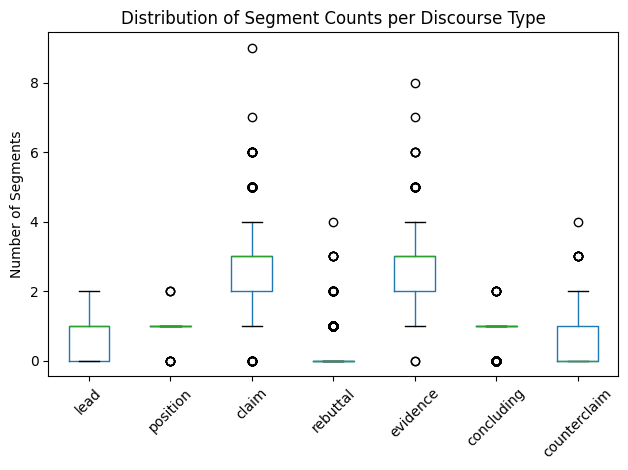

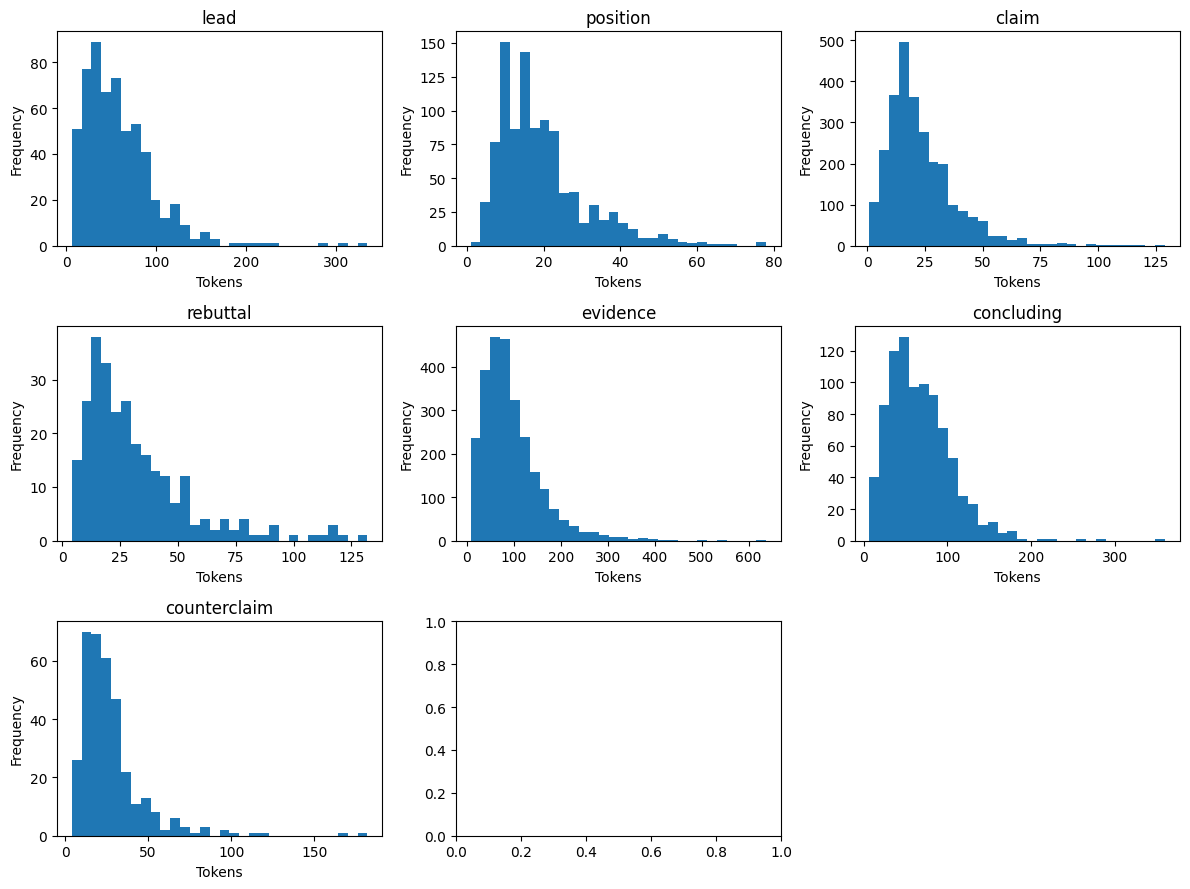

<Figure size 640x480 with 0 Axes>

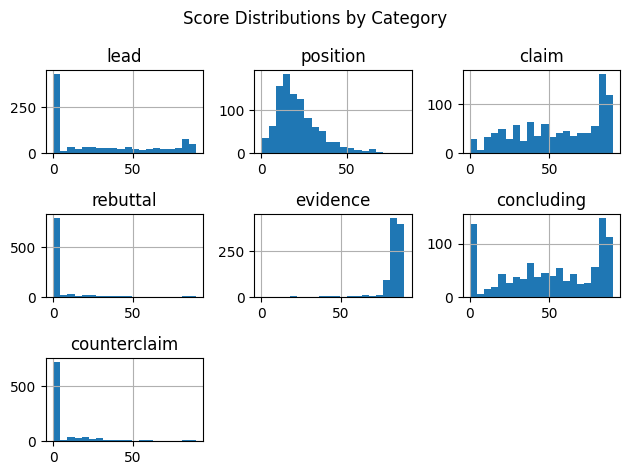

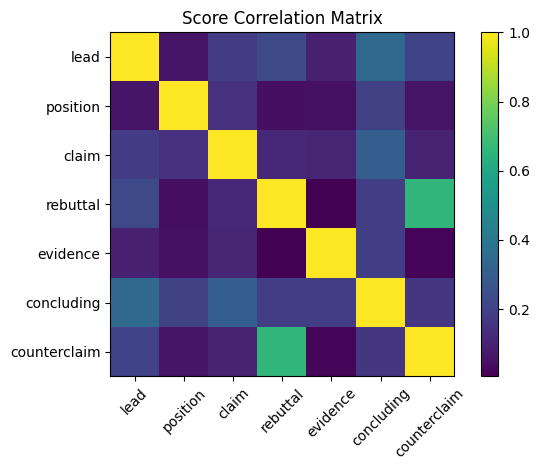

In [56]:
seg_counts = np.array([[len(ed['segments'][dt]) for dt in discourse_types] for ed in essay_data_list])
df_seg_counts = pd.DataFrame(seg_counts, columns=discourse_types)

plt.figure()
df_seg_counts.boxplot(grid=False)
plt.title("Distribution of Segment Counts per Discourse Type")
plt.ylabel("Number of Segments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

seg_lens = {dt: [] for dt in discourse_types}
for ed in essay_data_list:
    for dt in discourse_types:
        for seg in ed['segments'][dt]:
            seg_lens[dt].append(len(seg.split()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
axes = axes.flatten()
for idx, dt in enumerate(discourse_types):
    axes[idx].hist(seg_lens[dt], bins=30)
    axes[idx].set_title(dt)
    axes[idx].set_xlabel("Tokens")
    axes[idx].set_ylabel("Frequency")
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

scores = np.array([ed['score'] for ed in essay_data_list])
df_scores = pd.DataFrame(scores, columns=score_columns)

plt.figure()
df_scores.hist(bins=20)
plt.suptitle("Score Distributions by Category")
plt.tight_layout()
plt.show()

corr = df_scores.corr()
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(score_columns)), score_columns, rotation=45)
plt.yticks(range(len(score_columns)), score_columns)
plt.title("Score Correlation Matrix")
plt.tight_layout()
plt.show()


In [57]:
class EssayDataset(Dataset):
    def __init__(self, records, tokenizer): self.records = records
    def __len__(self): return len(self.records)
    def __getitem__(self, idx):
        rec = self.records[idx]
        scores = [float(s) for s in rec["score"]]
        return {"segments": rec["segments"], "labels": torch.tensor(scores, dtype=torch.float)}

In [58]:
def collate_fn(batch, tokenizer_instance, max_len):
    labels = torch.stack([b["labels"] for b in batch], dim=0)  # Stack labels from batch
    batched_text = {dt: [] for dt in discourse_types}  # Prepare a dictionary for discourse types
    for b in batch:
        for dt in discourse_types:
            segs = b["segments"].get(dt, [])  # Get segments for each discourse type
            batched_text[dt].append(" ".join(segs) if segs else tokenizer_instance.pad_token)  # Join segments or pad
    tokenized = {}
    for dt in discourse_types:
        tokenized[dt] = tokenizer_instance(  # Tokenize each discourse type
            batched_text[dt],
            padding='max_length',
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
            add_special_tokens=True,
            return_attention_mask=True
        )
    return tokenized, labels  # Return tokenized data and labels


## 2.2 Define Layers and combine layers for BERT with MoE

In [59]:
# BERT input embeddings
class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)  # sequence length
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        # embed tokens, positions, and types
        word_embeds = self.word_embeddings(input_ids)
        token_type_embeds = self.token_type_embeddings(token_type_ids)
        position_ids = self.position_ids[:, :seq_length].to(input_ids.device)
        position_embeds = self.position_embeddings(position_ids)
        # sum + norm + dropout
        embeddings = word_embeds + position_embeds + token_type_embeds
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


In [60]:
# BERT self-attention mechanism
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = config.attention_head_size
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # project to Q/K/V
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key   = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        # reshape + permute for multi-head
        new_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        # get Q, K, V
        q = self.transpose_for_scores(self.query(hidden_states))
        k = self.transpose_for_scores(self.key(hidden_states))
        v = self.transpose_for_scores(self.value(hidden_states))

        # compute scaled dot-product
        scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            scores = scores + attention_mask

        probs = nn.functional.softmax(scores, dim=-1)
        probs = self.dropout(probs)

        # combine heads
        context = torch.matmul(probs, v)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_shape = context.size()[:-2] + (self.all_head_size,)
        context = context.view(*new_shape)

        return context


In [61]:
# Output transformation for the attention block
class BertAttentionOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Dense layer (fully connected)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        # Layer normalization
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Dropout
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # Pass through dense + dropout
        hidden_states = self.dropout(self.dense(hidden_states))
        # Add residual connection and apply layer normalization
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


In [62]:
# self-attention + output wrapper
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)      # self-attn
        self.output = BertAttentionOutput(config)  # proj + add & norm

    def forward(self, hidden_states, attention_mask=None):
        # apply self-attn then output layer
        attn_output = self.self(hidden_states, attention_mask)
        return self.output(attn_output, hidden_states)


In [63]:
def get_activation(name):
    if name == "gelu": return nn.GELU()
    if name == "relu": return nn.ReLU()

In [64]:
# Intermediate transformation before the feed-forward network
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Dense layer to transform hidden states to intermediate size
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        # Activation function based on the configuration (e.g., GELU)
        self.intermediate_act_fn = get_activation(config.hidden_act)

    def forward(self, hidden_states):
        # Apply the dense layer followed by the activation function
        return self.intermediate_act_fn(self.dense(hidden_states))


In [65]:
# Output transformation for the BERT model, after the intermediate layer
class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Dense layer to map intermediate size back to hidden size
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        # Layer normalization applied to the output
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Dropout for regularization
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # Apply the dense layer followed by dropout
        hidden_states = self.dropout(self.dense(hidden_states))
        # Apply layer normalization and add residual connection
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


In [66]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)  # Attention layer
        self.intermediate = BertIntermediate(config)  # Intermediate feed-forward layer
        self.output = BertOutput(config)  # Output layer

    def forward(self, hidden_states, attention_mask=None):
        attention_output = self.attention(hidden_states, attention_mask)  # Apply attention
        intermediate_output = self.intermediate(attention_output)  # Apply intermediate layer
        layer_output = self.output(intermediate_output, attention_output)  # Apply output layer
        return layer_output


In [67]:
# BERT Encoder: Stacks multiple BertLayer for encoding
class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Create a list of BertLayer modules
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask=None):
        # Pass input through all layers sequentially
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
        return hidden_states


In [68]:
# BERT Model: Combines embeddings and encoder to process input
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)  # Embedding layer
        self.encoder = BertEncoder(config)  # Encoder (stack of layers)

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings  # Return word embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value  # Set word embeddings

    def _prune_heads(self, heads_to_prune):
        raise NotImplementedError  # Not implemented pruning functionality

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Create attention mask if not provided
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # Adjust attention mask dimensions
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # Embedding the input and passing through encoder
        embedding_output = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)
        sequence_output = self.encoder(embedding_output, attention_mask=extended_attention_mask)

        return {"last_hidden_state": sequence_output}  # Return the final output


In [69]:
# Mixture of Experts (MoE) Interaction: Implements expert-based routing mechanism
class MoEInteraction(nn.Module):
    def __init__(self, d_model=768, n_experts=len(discourse_types), k=2):
        super().__init__()
        self.gate = nn.Linear(d_model, n_experts)  # Gate to decide expert selection
        # List of experts (each is a 2-layer MLP)
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(d_model, d_model * 4), nn.GELU(), nn.Linear(d_model * 4, d_model)
        ) for _ in range(n_experts)])
        self.k = k  # Number of top experts to use
        self.n_experts = n_experts

    def forward(self, E):
        if E.shape[0] != self.n_experts:
            return torch.zeros_like(E)  # Return zero if number of experts mismatch

        gate_logits = self.gate(E)  # Get logits for expert selection
        topk_vals, topk_inds = torch.topk(gate_logits, self.k, dim=-1)  # Select top-k experts

        out = torch.zeros_like(E)  # Initialize output
        for i in range(E.size(0)):
            weights = torch.softmax(topk_vals[i], dim=-1)  # Normalize expert weights
            expert_outputs = []
            # Apply experts to the input
            for expert_index, weight in zip(topk_inds[i], weights):
                if expert_index < self.n_experts:
                    expert_outputs.append(weight.unsqueeze(0) * self.experts[expert_index](E[i]))
            if expert_outputs:
                out[i] = torch.stack(expert_outputs).sum(dim=0)  # Combine outputs from selected experts
        return out


In [70]:
# Hierarchical MoE Scorer: Uses MoE mechanism for scoring different discourse types
class HierarchicalMoEScorer(nn.Module):
    def __init__(self, bert_scratch_config, n_experts=len(discourse_types), k=2, num_labels=len(score_columns)):
        super().__init__()
        self.bert = BertModel(bert_scratch_config)  # BERT model for embedding
        bert_hidden_size = bert_scratch_config.hidden_size
        self.moe = MoEInteraction(d_model=bert_hidden_size, n_experts=n_experts, k=k)  # MoE for expert interaction
        self.heads = nn.ModuleList([nn.Linear(bert_hidden_size, 1) for _ in range(num_labels)])  # Output heads for each label
        self.discourse_types = discourse_types  # List of discourse types
        self.num_labels = num_labels  # Number of score labels
        self.config = bert_scratch_config

    def forward(self, tokenized_batch):
        B = tokenized_batch[self.discourse_types[0]]["input_ids"].size(0)  # Batch size
        device = next(self.parameters()).device  # Device (CPU/GPU)
        bert_hidden_size = self.config.hidden_size
        disc_embeddings = []

        # Process each discourse type and get embeddings
        for dt in self.discourse_types:
            ids = tokenized_batch[dt]["input_ids"].to(device)
            mask = tokenized_batch[dt]["attention_mask"].to(device)
            last_hidden_state = self.bert(input_ids=ids, attention_mask=mask)["last_hidden_state"]
            disc_embeddings.append(last_hidden_state[:, 0, :])  # Take the [CLS] token representation

        # Stack embeddings across all discourse types
        E = torch.stack(disc_embeddings, dim=1)
        H_all = []

        # Apply MoE mechanism for each batch
        for i in range(B):
            H_all.append(self.moe(E[i]))
        H = torch.stack(H_all, dim=0)

        # Pool over discourse types and apply the output heads
        pooled_H = H.mean(dim=1)  # Mean pooling across experts
        outs = [self.heads[j](pooled_H).squeeze(-1) for j in range(self.num_labels)]
        final_preds = torch.stack(outs, dim=1)  # Stack predictions for all labels
        return final_preds


## 2.3 Training the model

In [78]:
from sklearn.metrics import mean_squared_error, r2_score

def train_model(model, train_loader, val_loader, epochs=5, lr=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device - {device}")
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # For logging
    train_losses = []
    val_losses = []
    rmse_scores = []
    r2_scores = []
    avg_rmse_scores = []
    avg_r2_scores = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        for tokenized, labels in progress_bar:
            for dt in model.discourse_types:
                tokenized[dt] = {k: v.to(device) for k, v in tokenized[dt].items()}
            labels = labels.to(device)
            preds = model(tokenized)

            if preds.shape != labels.shape:
                continue

            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)

        with torch.no_grad():
            for tokenized, labels in val_progress_bar:
                for dt in model.discourse_types:
                    tokenized[dt] = {k: v.to(device) for k, v in tokenized[dt].items()}
                labels = labels.to(device)
                preds = model(tokenized)

                if preds.shape == labels.shape:
                    loss = criterion(preds, labels)
                    val_loss += loss.item()

                val_preds.append(preds.cpu().numpy())
                val_true.append(labels.cpu().numpy())
                val_progress_bar.set_postfix(loss=loss.item() if 'loss' in locals() else float('nan'))

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_losses.append(avg_val_loss)
        val_preds = np.vstack(val_preds) if val_preds else np.array([])
        val_true = np.vstack(val_true) if val_true else np.array([])

        if val_preds.size > 0 and val_true.size > 0:
            rmse = np.sqrt(mean_squared_error(val_true, val_preds, multioutput='raw_values'))
            r2 = r2_score(val_true, val_preds, multioutput='raw_values')
            avg_rmse = np.mean(rmse)
            avg_r2 = np.mean(r2)

            rmse_scores.append(rmse)
            r2_scores.append(r2)
            avg_rmse_scores.append(avg_rmse)
            avg_r2_scores.append(avg_r2)

            print(f"Validation Loss: {avg_val_loss:.4f}")
            print(f"Overall Validation RMSE: {avg_rmse:.4f}")
            print(f"Overall Validation R²: {avg_r2:.4f}")

            for name, score, r2s in zip(score_columns, rmse, r2):
                print(f"  RMSE - {name}: {score:.4f} | R² - {name}: {r2s:.4f}")
        else:
            print(f"Validation Loss: {avg_val_loss:.4f}")

    # Return logs for plotting
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "rmse_scores": rmse_scores,
        "r2_scores": r2_scores,
        "avg_rmse_scores": avg_rmse_scores,
        "avg_r2_scores": avg_r2_scores
    }


In [79]:
# Split data into training and validation sets
train_records, val_records = train_test_split(essay_data_list, test_size=0.2, random_state=42)
print(f"Data split: {len(train_records)} train, {len(val_records)} validation records.")

# Initialize tokenizer and build vocabulary
tokenizer = SimpleTokenizer(vocab_limit=12000)
tokenizer.build_vocab(train_records)
print(f"Vocab Size: {tokenizer.vocab_size}")

# Prepare datasets and dataloaders
train_data = EssayDataset(train_records, tokenizer)
val_data = EssayDataset(val_records, tokenizer)
collate_fn_with_args = partial(collate_fn, tokenizer_instance=tokenizer, max_len=MAX_LEN_COLLATE)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn_with_args, num_workers=0)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, collate_fn=collate_fn_with_args, num_workers=0)

# Configure BERT model settings
bert_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=MAX_LEN_COLLATE,
    pad_token_id=tokenizer.pad_token_id
)
print(f"BERT Config: vocab={bert_config.vocab_size}, hidden={bert_config.hidden_size}, layers={bert_config.num_hidden_layers}, pad_id={bert_config.pad_token_id}")

# Initialize model
model = HierarchicalMoEScorer(bert_scratch_config=bert_config, n_experts=len(discourse_types), k=2, num_labels=len(score_columns))


Data split: 800 train, 200 validation records.
Building vocabulary from 800 records...


Processing Corpus:   0%|          | 0/800 [00:00<?, ?it/s]

Adding words to vocab:   0%|          | 0/10556 [00:00<?, ?it/s]

Vocabulary building complete. Size: 10560
Vocab Size: 10560
BERT Config: vocab=10560, hidden=768, layers=6, pad_id=0


In [ ]:
A = train_model(model, train_loader, val_loader, epochs=20, lr=1e-4)

## 2.4 Testing the Model

In [ ]:
def evaluate_model(model, data_loader, discourse_types, device=None, compute_f1=False):
    model.eval()  # Set to eval mode
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds, all_labels = [], []  # Lists to store predictions and labels
    total_mse = 0.0
    mse_loss = torch.nn.MSELoss(reduction='mean')  # MSE loss

    with torch.no_grad():  # No gradient calculation
        for tokenized, labels in data_loader:
            # Move tokenized inputs and labels to device
            for dt in discourse_types:
                tokenized[dt] = {k: v.to(device) for k, v in tokenized[dt].items()}
            labels = labels.to(device)
            preds = model(tokenized)
            loss = mse_loss(preds, labels)
            total_mse += loss.item() * labels.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Aggregate results
    Y_pred = np.vstack(all_preds)
    Y_true = np.vstack(all_labels)
    N, D = Y_true.shape  # Number of samples and outputs

    # Calculate RMSE and R2
    rmse_per_disc = np.sqrt(mean_squared_error(Y_true, Y_pred, multioutput='raw_values'))
    overall_rmse = np.sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))
    r2_per_disc = r2_score(Y_true, Y_pred, multioutput='raw_values')
    overall_r2 = r2_score(Y_true.ravel(), Y_pred.ravel())
    avg_mse_loss = total_mse / N

    results = {"rmse_per_disc": rmse_per_disc, "overall_rmse": overall_rmse,
               "r2_per_disc": r2_per_disc, "overall_r2": overall_r2,
               "avg_mse_loss": avg_mse_loss}

    if compute_f1:  # F1 score if needed
        Yp_int = np.rint(Y_pred).astype(int)
        Yt_int = np.rint(Y_true).astype(int)
        f1_per_disc = [f1_score(Yt_int[:, j], Yp_int[:, j], average='macro', zero_division=0) for j in range(D)]
        overall_f1 = f1_score(Yt_int.ravel(), Yp_int.ravel(), average='macro', zero_division=0)
        results.update({"f1_per_disc": np.array(f1_per_disc), "overall_f1": overall_f1})

    return results  # Return metrics


In [ ]:
metrics=evaluate_model(model,val_loader,discourse_types,compute_f1=True)
for dt,rmse,r2,f1 in zip(discourse_types,metrics["rmse_per_disc"],metrics["r2_per_disc"]):
    print(f"{dt:20s} | RMSE: {rmse:.4f} | R2: {r2:.4f}")
print("\nOverall:")
print(f"\tRMSE: {metrics['overall_rmse']:.4f}")
print(f"\tR2:   {metrics['overall_r2']:.4f}")


lead                 | RMSE: 2.8818 | R2: 0.287
position             | RMSE: 1.2596 | R2: 0.798
claim                | RMSE: 2.6655 | R2: 0.837
rebuttal             | RMSE: 1.4198 | R2: 0.021
evidence             | RMSE: 1.5060 | R2: 0.127
concluding           | RMSE: 2.8743 | R2: 0.507
counterclaim         | RMSE: 1.4447 | R2: 0.012

Overall:
	RMSE: 2.1257
	R2:   0.6077


In [ ]:
def predict_on_training_example(model, training_example, tokenizer, discourse_types, score_columns, max_length=128, device=None):
    # Extract segments and true labels from training example
    segments_dict = training_example['segments']
    true_labels_list = training_example['score']
    true_labels = torch.tensor([float(s) for s in true_labels_list], dtype=torch.float)

    model.eval()  # Set model to eval mode
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    true_labels = true_labels.to(device)

    # Prepare batched input for each discourse type
    batched_text = {dt: [" ".join(segments_dict.get(dt, [])) if segments_dict.get(dt) else tokenizer.pad_token] for dt in discourse_types}

    # Tokenize inputs
    tokenized_batch = {dt: {k: v.to(device) for k, v in tokenizer(batched_text[dt], padding='max_length', truncation=True, max_length=max_length, return_tensors="pt", add_special_tokens=True, return_attention_mask=True).items() if isinstance(v, torch.Tensor)} for dt in discourse_types}

    predicted_scores = None
    with torch.no_grad():  # No gradient calculation
        preds_batch = model(tokenized_batch)
        predicted_scores = preds_batch.squeeze(0).to(device)  # Get predictions

    # Calculate overall predicted score
    overall_predicted = predicted_scores.mean().item() if predicted_scores is not None else float('nan')

    return predicted_scores, overall_predicted, true_labels  # Return predicted and true labels


In [ ]:
example_index = 1
single_example = essay_data_list[example_index]

# Print input segments (first few chars)
print(f"Input Segments (showing first few chars):")
for dt, segs in single_example['segments'].items():
    print(f"  {dt}: {' | '.join([s[:50]+'...' if len(s)>50 else s for s in segs[:2]])}")

# Get prediction and true labels
predicted_scores, overall_predicted, true_labels = predict_on_training_example(
    model,
    single_example,
    tokenizer,
    discourse_types,
    score_columns,
    max_length=MAX_LEN_COLLATE,
)

# Display prediction results
print(f"\nPrediction for Example {example_index}:")
print("-" * 40)
for i, score_name in enumerate(score_columns):
    pred_val = predicted_scores[i].item() if predicted_scores is not None else float('nan')
    true_val = true_labels[i].item() if true_labels is not None else float('nan')
    print(f"{score_name:<15} | {pred_val:<10.3f} | {true_val:<10.3f}")
print("-" * 40)
print(f"{'Overall Mean':<15} | {overall_predicted:<10.3f} | {true_labels.mean().item():<10.3f}")


Input Segments (showing first few chars):
  lead: We , the people of Florida are concerned about the...
  position: I believe that the Electoral College should not be...
  claim: it lacks reasoning , it is unfair to voters | misloyalty and mistakes can easily occur
  rebuttal: 
  evidence: In the article , The Indefensible Electoral Colleg... | When a tie occurs in the electoral vote , the elec...
  concluding: The Electoral College has been used for several ye...
  counterclaim: 

Prediction for Example 1:
----------------------------------------
lead            | 31.365     | 36.000    
position        | 25.287     | 22.000    
claim           | 63.162     | 80.000    
rebuttal        | 7.266      | 0.000     
evidence        | 81.743     | 80.000    
concluding      | 56.828     | 55.000    
counterclaim    | 8.815      | 0.000     
----------------------------------------
Overall Mean    | 39.209     | 39.000    


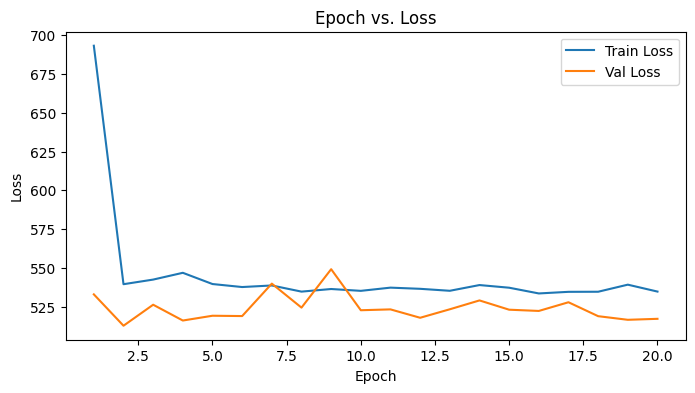

In [86]:
# Loss plot
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(8, 4))
plt.plot(epochs, A['train_losses'], label='Train Loss')
plt.plot(epochs, A['val_losses'],   label='Val Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()